In [ ]:
!pip install git+https://github.com/instadeepai/jumanji.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/instadeepai/jumanji.git to /tmp/pip-req-build-i95mhw4b
  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/jumanji.git /tmp/pip-req-build-i95mhw4b
  Resolved https://github.com/instadeepai/jumanji.git to commit 10958866909d434ba50edc1915247e4cebc3cb3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.3/471.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/

In [ ]:
import numpy as np
def flatten(obs):
  p=[]  # obs = timestep.observation 
  p = np.append(obs.ems.x1,obs.ems.x2)
 #p = np.append(p,obs.ems.x2)
  p = np.append(p,obs.ems.y1)
  p = np.append(p,obs.ems.y2)
  p = np.append(p,obs.ems.z1)
  p = np.append(p,obs.ems.z2)
  p = np.append(p,obs.ems_mask.flatten())
  p = np.append(p,obs.items.x_len)
  p = np.append(p,obs.items.y_len)
  p = np.append(p,obs.items.z_len)
  p = np.append(p,obs.items_mask.flatten())
  p = np.append(p,obs.items_placed.flatten())
  return p 

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from jumanji.wrappers import AutoResetWrapper

from gym import spaces
from collections import deque
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        #x, y, u, r = [], [], [], []
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1) , np.array(d).reshape(-1,1)

In [ ]:
class FeedForwardNeuralNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(FeedForwardNeuralNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.dense_layer_3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        x = F.relu(self.dense_layer_3(x))
        return self.output(x)

In [ ]:
import jax
import jax.numpy as jnp
from torch.distributions import MultivariateNormal,Categorical

In [ ]:
class DQN():
  def __init__(self, state_size, action_size, hidden_size, learning_rate ):
    self.action_size = action_size
    self.train_net = FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
    self.target_net = FeedForwardNeuralNet(state_size, action_size, hidden_size).to(device)
    self.target_net.load_state_dict(self.train_net.state_dict())
    self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        
  def select_action(self, state, epsilon):
    # select action according to epsilon-greedy method
    num_ems, num_items = env.action_spec().num_values 
    if np.random.rand() <= epsilon:
      ems_item_id = jax.random.choice( 
          key=jax.random.PRNGKey(0), 
          a=num_ems * num_items, 
          p=timestep.observation.action_mask.flatten(), 
          ) 
      ems_id, item_id = jnp.divmod(ems_item_id, num_items) 
      # Wrap the action as a jax array of shape (2,) 
      action = jnp.array([ems_id, item_id]) 
    else:
      # greedy action is the largest Q value from the train network based on the input
      with torch.no_grad():
        input_state = torch.FloatTensor(state).to(device)
        # feed input into the network and get the max action value
        ems_item_id = self.train_net(input_state).max(0)[1].view(-1)
        ems_item_id = int(ems_item_id)
        ems_id, item_id = jnp.divmod(ems_item_id, num_items) 
        action = jnp.array([ems_id, item_id]) 
        
    return action

  def train(self, replay_buffer, batch_size, discount):
    # train the training network
    # sample a batch from the replay buffer
    x0, x1, a, r, d = replay_buffer.sample(batch_size)
    #x0, x1, a, r = replay_buffer.sample(batch_size)

    # turn batches into tensors and attack to GPU if available
    state_batch = torch.FloatTensor(x0).to(device)
    next_state_batch = torch.FloatTensor(x1).to(device)
    action_batch = torch.LongTensor(a).to(device)
    reward_batch = torch.FloatTensor(r).to(device)
    done_batch = torch.FloatTensor(1 - d).to(device)

    # get train net Q values
    train_q = self.train_net(state_batch)
        
    # get target net Qvalues
    with torch.no_grad():
      target_net_q = reward_batch + done_batch * discount * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)

    # create loss function
    loss_fn = nn.MSELoss()
    # get loss between train q values and target q values
    loss = loss_fn(train_q, target_net_q)
    # optimize the parameters with the loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    # we return the loss so we can monitor loss and debug the network if necessary
    return loss.detach().cpu().numpy()
    
  def update_target_network(self, num_iter, update_every):
    # update target network every so often
    # hard target network update: updates target network fully with train network params
    if num_iter % update_every == 0:
      self.target_net.load_state_dict(self.train_net.state_dict())

In [ ]:
# initialize environment

import jax
import jax.numpy as jnp
import jumanji
env = jumanji.make("BinPack-toy-v0")
env = AutoResetWrapper(env) 
dummy_obs = env.observation_spec().generate_value()
dummy_obs = flatten(env.observation_spec().generate_value())
num_ems, num_items = env.action_spec().num_values

action_size =  num_ems * num_items
state_size = dummy_obs.shape[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 100000 # run agent for this many episodes
start_training_after = 10000 # collect data for this many timesteps before training
hidden_size = 128 # number of units in NN hidden layers
learning_rate = 0.000005 # learning rate for optimizer
update_target_every_ts = 1000 # update target network after this many steps
batch_size = 128 # mini batch size we train network on
discount = 0.3 # gamma value

epsilon_start = 1.0 # epsilon start value
epsilon_min = 0.01  # epsilon end value
epsilon_decay_steps = episodes * .95 # decay epsilon over this many episodes
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

# create replay buffer
replay_size = 25000
replay_buffer = ReplayBuffer(max_size=replay_size)

# create cartpole agent
BinPacking = DQN(state_size, action_size, hidden_size, learning_rate)

In [ ]:
import warnings  
warnings.filterwarnings('ignore') 
stats_rewards_list = [] # store stats for plotting in this 
batch_states = [] 
answ= []
stats_every = 10 # print stats every this many episodes 
total_reward = 0 
timesteps = 0 
episode_length = 0 
epsilon = epsilon_start 
 
 
step_fn = jax.jit(env.step) 
reset_fn = jax.jit(env.reset) 
 
for ep in range(episodes): 
  key = jax.random.PRNGKey(0) 
  state, timestep = reset_fn(key) 
  state_flt = flatten(timestep.observation) 
 
  stats_loss = 0 
     
  # stopping condition for training if agent reaches the amount of reward 
  if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190: 
      print("Stopping at episode {} with average rewards of {} in last {} episodes". 
          format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every)) 
      break   
     
  # train in each episode until episode is done 
  while True: 
    timesteps += 1 
    #env.render() 
    # select an action from the agent's policy 
    action = BinPacking.select_action(state_flt, epsilon)
    # enter action into the env 
    #next_state, timestep = jax.jit(env.step)(state, action)  
    next_state, timestep = step_fn(state, action) 
    next_state_flt = flatten(timestep.observation) 
    reward =np.array(timestep.reward.flatten())[0]
    total_reward += reward 
    episode_length += 1 
 
 
    #print("timestep.extras['volume_utilization'].flatten()") 
    #print(timestep.extras['volume_utilization'].flatten()[0]) 
 
    batch_states.append(state) 
    #done = True if timestep.last() else False 
    done = True if reward!=0 else False
    if done: 
      reward = -1
      #replay_buffer.add((state_flt, np.zeros(state_flt.shape), action, reward, done))
      replay_buffer.add((state_flt, next_state_flt, action, reward, done))
      #answ.append((state_flt, next_state_flt, action, reward, done)) 
      stats_rewards_list.append((ep, total_reward, episode_length)) 
      total_reward = 0 
      episode_length = 0 
      epsilon -= epsilon_step 
      if epsilon < epsilon_min: 
        epsilon = epsilon_min 
                 
      if timesteps > start_training_after and ep % stats_every == 0: 
        print('Episode: {}'.format(ep), 
                  'Timestep: {}'.format(timesteps), 
                  'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]), 
                  'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]), 
                  'Epsilon: {:.2f}'.format(epsilon), 
                  'Loss: {:.3f}'.format(stats_loss)) 
      # for i in answ:
      #   replay_buffer.add((i[0], i[1], i[2], reward, i[4])) 
      # answ = []  
      break 
    else:
      #answ.append((state_flt, next_state_flt, action, reward, done)) 
      replay_buffer.add((state_flt, next_state_flt, action, reward, done)) 
    state = next_state 
    state_flt= next_state_flt
    if timesteps > start_training_after: 
      # train the agent 
      stats_loss += BinPacking.train(replay_buffer, batch_size, discount) 
      # update the target network every (if conditions are met in update_target_network) 
      BinPacking.update_target_network(timesteps, update_target_every_ts)

Text(0, 0.5, 'Episode Reward')

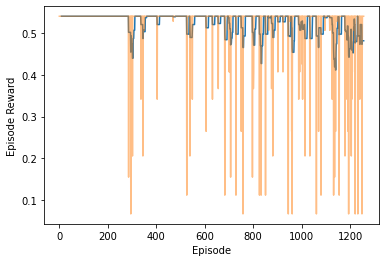

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

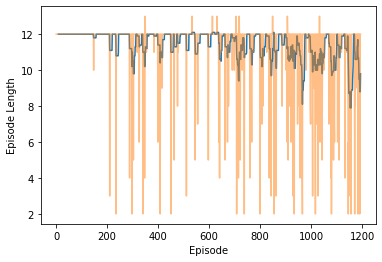

In [ ]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

KeyboardInterrupt: ignored

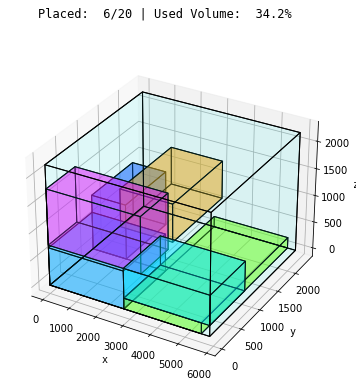

In [ ]:
import time
for i in range(1000):
  env.render(batch_states[i])
  time.sleep(0.5)